In [1]:
import tensorflow as tf
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle as pkl
from PIL import Image
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import layers,Model

In [2]:
vgg16 = VGG16(weights='imagenet')
feature_extract = Model(inputs = vgg16.input, outputs = vgg16.layers[-2].output)

In [3]:
feature = dict()
for img_name in tqdm(os.listdir('Images')[:100]):
    # img = load_img('Images/'+ img_name, target_size=(224,224))
    img = Image.open('Images/'+ img_name).resize((224,224))
    img = img_to_array(img)
    img = img[None,:]
    img = preprocess_input(img)
    feature[img_name] = feature_extract.predict(img)

100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


In [4]:
df = pd.read_csv('captions.txt')#.iloc[:500,:]

In [5]:
train_df, remain_df = train_test_split(df, 
                                        test_size=0.2,
                                        random_state=42)

val_df, test_df = train_test_split(remain_df, 
                                    test_size = 0.5,
                                    random_state=42)
train_df.reset_index(drop = True, inplace = True)
val_df.reset_index(drop = True, inplace = True)
test_df.reset_index(drop = True, inplace = True)

In [6]:
START_TOKEN = 'startseq'
END_TOKEN = 'endseq'
def preprocess_caption(s):
    s = START_TOKEN + ' ' + s + ' ' + END_TOKEN
    s = s.lower()
    s = re.sub(r'[^\w\s]','',s)
    s = re.sub(r'\s+',' ',s)
    return s
df.caption = df.caption.apply(preprocess_caption)

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.caption)
vocab_size = len(tokenizer.word_index) + 1
max_len = max(df.caption.str.split().agg(len))

In [8]:
with open('tokenizer.pkl', 'wb+') as f:
    pkl.dump(tokenizer,f)

In [8]:
class Dataloader(tf.keras.utils.Sequence):
    def __init__(self, df, feature, batch_size, tokenizer, max_len, vocab_size):
        self.df = df
        self.batch_size = batch_size
        self.feature = feature
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.n = len(self.df)
    
    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        
        X1, X2, y = list(), list(), list()
        for i in range(start, end):
            img_name = self.df.loc[i,'image']
            captions = self.df.loc[df.image == img_name, 'caption']
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen= self.max_len)[0]
                    out_seq = to_categorical([out_seq], num_classes= self.vocab_size)[0]
                    X1.append(self.feature[img_name][0])
                    X2.append(in_seq)
                    y.append(out_seq)
        return (np.array(X1), np.array(X2)), np.array(y)
    
    def __len__(self):
        return self.n // self.batch_size

# Model

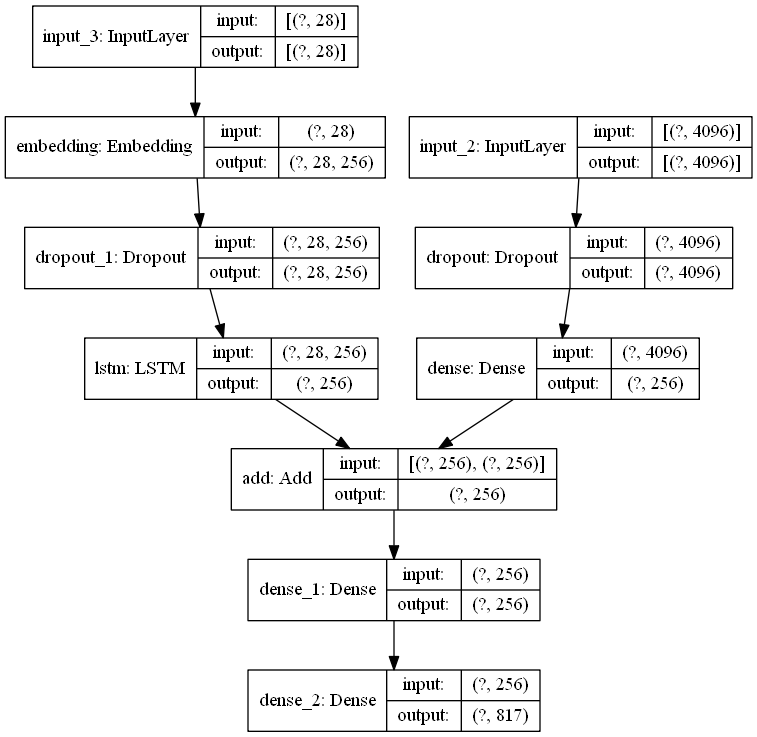

In [9]:
input1 = layers.Input(shape=(4096,))
fe1 = layers.Dropout(0.5)(input1)
fe2 = layers.Dense(256, activation= 'relu')(fe1)

input2 = layers.Input(shape=(max_len,))
enc1 = layers.Embedding(vocab_size,
                        256,
                        mask_zero=True
                        )(input2)
enc2 = layers.Dropout(0.5)(enc1)
enc3 = layers.LSTM(256)(enc2)

decoder1 = layers.add([fe2, enc3])
decoder2 = layers.Dense(256, activation = 'relu')(decoder1)
output = layers.Dense(vocab_size, activation = 'softmax')(decoder2)

model = Model(inputs = [input1, input2],
                outputs = output)

model.compile(
        loss = 'categorical_crossentropy',
        optimizer = 'adam'
        )

plot_model(model, show_shapes = True)

In [10]:
BATCH_SIZE = 32
EPOCHS = 3
train_dataloader = Dataloader(df = train_df, 
                              feature = feature, 
                              batch_size = BATCH_SIZE,
                              tokenizer = tokenizer,
                              max_len = max_len,
                              vocab_size = vocab_size)
val_dataloader = Dataloader(df = val_df, 
                              feature = feature, 
                              batch_size = BATCH_SIZE,
                              tokenizer = tokenizer,
                              max_len = max_len,
                              vocab_size = vocab_size)
test_dataloader = Dataloader(df = test_df, 
                              feature = feature, 
                              batch_size = BATCH_SIZE,
                              tokenizer = tokenizer,
                              max_len = max_len,
                              vocab_size = vocab_size)

In [11]:
model_save = 'model.h5'

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = model_save,
        mode = 'min',
        save_best_only=True,
        save_weights_only=True,
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        min_delta=.0001
    )
]

In [12]:
history = model.fit(
        train_dataloader,
        epochs = EPOCHS,
        validation_data = val_dataloader,
        callbacks = callbacks,
        )

Epoch 1/3
12/12 [==============================] - 21s 2s/step - loss: 5.8116 - val_loss: 5.3196
Epoch 2/3
12/12 [==============================] - 20s 2s/step - loss: 5.0995 - val_loss: 5.3449
Epoch 3/3
12/12 [==============================] - 20s 2s/step - loss: 4.8013 - val_loss: 5.4560


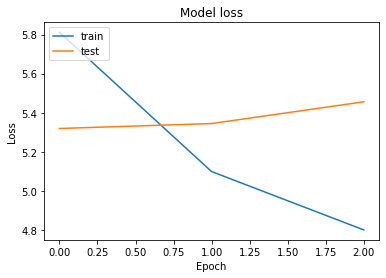

In [13]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"], loc = "upper left")
plt.show()

In [14]:
result = model.evaluate(test_dataloader)
print(f"Test loss, test accuracy: {result}")

1/1 [==============================] - 0s 1000us/step - loss: 5.9919
Test loss, test accuracy: 5.991888999938965


In [15]:
def predict(image_name, feature_extract, model, tokenizer, max_len, start_token = 'startseq', end_token = 'endseq'):
    output = start_token
    img = load_img(image_name, target_size=(224,224))
    img = img_to_array(img)
    img = img[None,:]
    img = preprocess_input(img)
    img_feature = feature_extract.predict(img)
    for i in range(max_len):
        sequence = tokenizer.texts_to_sequences([output])[0]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = model.predict([img_feature, sequence])
        idx = np.argmax(yhat)
        if idx in tokenizer.index_word:
            token = tokenizer.index_word[idx]
            output += ' ' + token
            if token == end_token:
                break
    return output

In [16]:
image_name = '1045521051_108ebc19be.jpg'
print('Real: ',test_df[test_df.image == image_name].caption.tolist())
predict('Images/'+image_name, feature_extract, model, tokenizer, max_len)

Real:  ['A television with a picture of a girl on it .', 'A young man sits on the floor by the television with a fast food meal in front of him .']


'startseq boy boy a a a a a a a a a a a a a a a a a a a a a a a a a a'

In [17]:
image_name = '1009434119_febe49276a.jpg'
print('Real: ',test_df[test_df.image == image_name].caption.tolist())
predict('Images/'+image_name, feature_extract, model, tokenizer, max_len)

Real:  ['A Boston Terrier is running on lush green grass in front of a white fence .']


'startseq in in in in a a in a a in a in a in in a in in in a in in in a in in in in'